In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#from BRScraper import nba

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
#import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [81]:
df1 = pd.read_excel('NBA Talent Analysis Part BandC data.xlsx', sheet_name = 'NBA Data')
df2 = pd.read_excel('NBA Talent Analysis Part BandC data.xlsx', sheet_name = 'NBA Salary Cap History')

In [82]:
df1.head()

,Player,Deal Average Salary,Deal_Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,3PAr,FTr,USG%,OWS,DWS,WS,RFA
0,Klay Thompson,37980720,2019,29,78,78,2652,655,1402,0.47,241,599,0.40,0.55,129,158,0.82,37,262,299,186,84,47,115,157,1680,0.43,0.11,25.60,2.90,2.30,5.30,0
1,Tobias Harris,36000000,2019,27,82,82,2847,611,1254,0.49,156,393,0.40,0.55,266,307,0.87,69,576,645,229,51,37,151,184,1644,0.31,0.24,22.80,4.50,2.60,7.10,0
2,Khris Middleton,35500000,2019,28,77,77,2393,506,1148,0.44,179,474,0.38,0.52,216,258,0.84,50,411,461,331,80,7,174,172,1407,0.41,0.23,25.10,2.50,3.60,6.10,0
3,Kevin Durant,41063925,2019,31,78,78,2702,721,1383,0.52,137,388,0.35,0.57,448,506,0.89,33,464,497,457,58,84,225,155,2027,0.28,0.37,29.00,8.60,2.90,11.50,0
4,Kristaps Porzingis,31650600,2019,24,48,48,1553,390,889,0.44,90,228,0.40,0.49,218,275,0.79,62,254,316,57,36,115,93,141,1088,0.26,0.31,31.00,1.40,1.80,3.20,1


In [83]:
new_header = df2.iloc[0]  # take the first row for the header
df2 = df2[1:]  # take the data less the header row
df2.columns = new_header  # set the header row as the df header

# Drop any unnamed columns
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]

# Optionally, convert columns to more appropriate data types
df2['Salary Cap'] = df2['Salary Cap'].astype(int)
df2['Luxury Tax Line'] = df2['Luxury Tax Line'].astype(int)
df2['Salary Cap'] = df2['Salary Cap']/1000000
df2['Luxury Tax Line'] = df2['Luxury Tax Line']/1000000
df2.head()

,Season,Salary Cap,Luxury Tax Line
1,2019–20,109.14,132.63
2,2018–19,101.87,123.73
3,2017–18,99.09,119.27
4,2016–17,94.14,113.29
5,2015–16,70.00,84.74


In [84]:
df2['Season'] = df2['Season'].apply(lambda x: int(x.split('–')[0]))

# Rename the column in df2 to match df1 for merging
df2.rename(columns={'Season': 'Deal_Year'}, inplace=True)

# Merge df1 and df2
merged_df = pd.merge(df1, df2, on='Deal_Year', how='left')


## Data Wrangling 

In [85]:
sns.set(style='dark')
sns.set_theme(rc={'figure.dpi': 200}, font_scale=0.6)

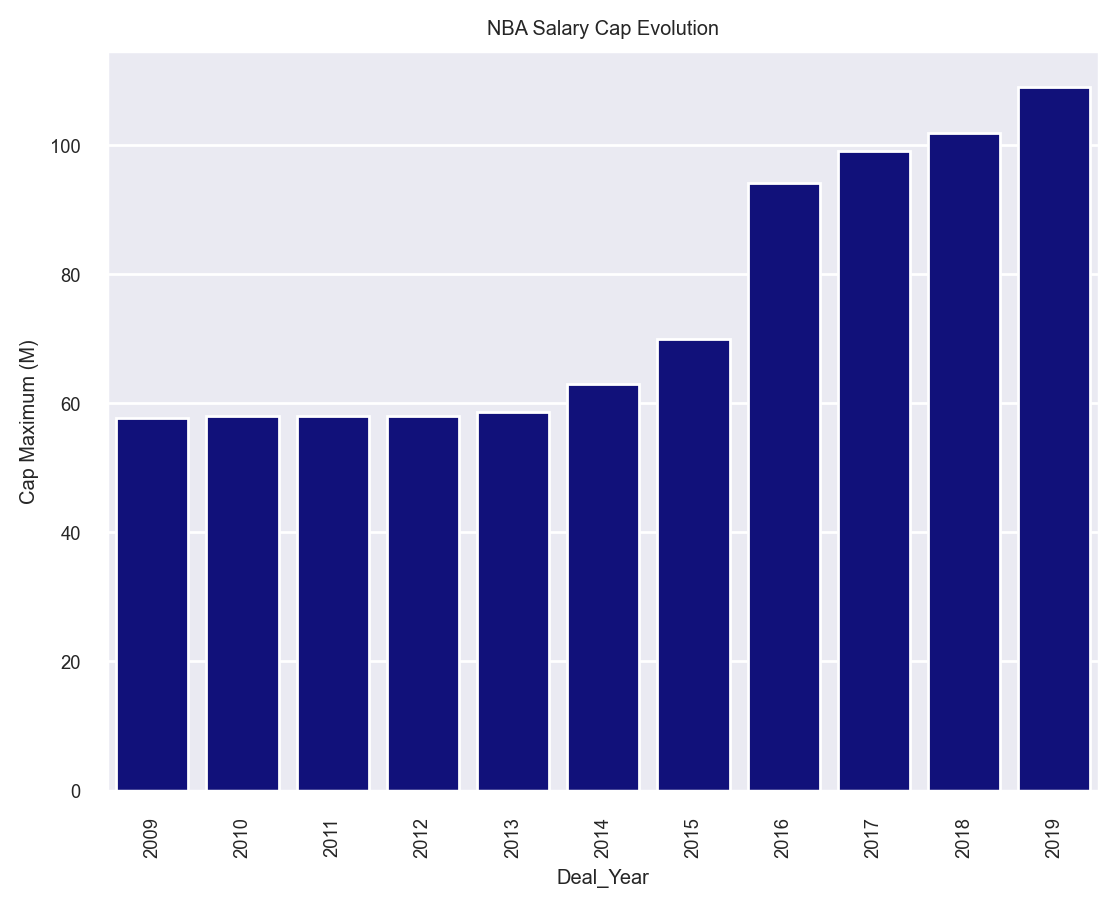

In [86]:
plt.xticks(rotation=90)
evol = sns.barplot(data=df2,x='Deal_Year',y='Salary Cap',color='darkblue').set(title='NBA Salary Cap Evolution')
plt.ylabel('Cap Maximum (M)');
#plt.savefig(path_data+sep+"salary_cap.jpg", dpi=300)

Text(0, 0.5, 'Number of players')

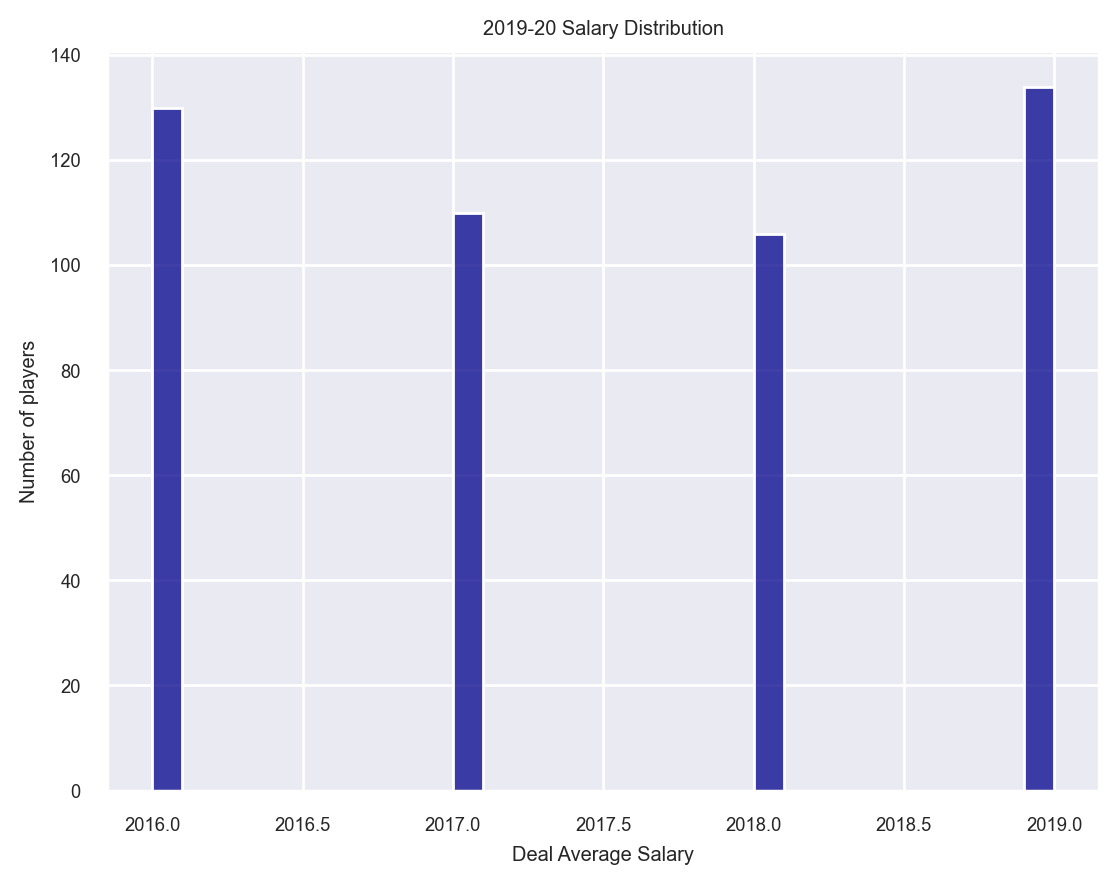

In [87]:
sns.histplot(data=df1,x='Deal_Year',bins=30,color='darkblue').set(title='2019-20 Salary Distribution');
plt.xlabel('Deal Average Salary')
plt.ylabel('Number of players')
#plt.savefig(path_data+sep+"salary_dist.jpg",dpi=300)

## Model

In [88]:
merged_df.columns

Index(['Player', 'Deal Average Salary', 'Deal_Year', 'Age', 'G', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', '3PAr',
       'FTr', 'USG%', 'OWS', 'DWS', 'WS', 'RFA', 'Salary Cap',
       'Luxury Tax Line'],
      dtype='object')

In [97]:
def func_metrics(y_test, y_pred, metrics, modelo):
    
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    #acc = round(accuracy_score(y_test, np.round(y_pred)),3)
    dict_met = {'Model': [modelo],
                'RMSE': [rmse],
                'R²': [r2]
                }
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics
def train_test_data(merged_df, df):
    print("Merged DF Length:", len(merged_df))
    print("DF Length:", len(df))

    # Check if both DataFrames align
    assert len(merged_df) == len(df), "The DataFrames do not align!"

    X = merged_df.drop(columns={'Player', 'Deal Average Salary', 'Deal_Year', 'Salary Cap', 'Luxury Tax Line'})
    #X = merged_df.drop(columns={'Player', 'Deal Average Salary', 'Deal_Year'})
    y = df['Deal Average Salary']

    # Check consistent lengths before splitting
    assert len(X) == len(y), "Feature and target variable lengths do not match!"

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=42)
    
    X_test = X_test.sample(frac=1, random_state=42)
    y_test = y_test.sample(frac=1, random_state=42)
    
    return X_train, X_test, y_train, y_test

# Example usage
#merged_df = df  # Make sure merged_df is correctly defined or aligned with df if they should be the same
X_train, X_test, y_train, y_test = train_test_data(merged_df,merged_df)


models = ['SVM','Random Forest','Elastic Net','AdaBoost','Gradient Boosting','XGBoost']
def func_scaler(X_train, X_test):
    
    scaler = StandardScaler()

    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    #pickle.dump(scaler,open(path_data+sep+'Modelos'+sep+'standard_scaler_FAs.dat','wb'))
    
    return scaled_X_train, scaled_X_test


Merged DF Length: 480
DF Length: 480


In [98]:
def func_models(scaled_X_train, scaled_X_test, y_train, y_test, models):
    metrics = pd.DataFrame()
    best_params = []
    
    path_data = "/Users/chhavisharma/Downloads"
    os.makedirs(path_data, exist_ok=True)
    
    for modelo in models:
        # Creating instance for each model
        if modelo=='SVM':
            param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5],
                         'kernel': ['linear','rbf','poly'],
                         'gamma': ['scale','auto'],
                         'degree': [2,3,4],
                         'epsilon': [0.1,0.5,1]}
            svr_model = SVR()
            grid = GridSearchCV(svr_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = SVR(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Elastic Net':
            param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                          'l1_ratio':[0.01,0.1,0.5,0.7,0.95,1]}
            elastic_net_model = ElasticNet()
            grid = GridSearchCV(elastic_net_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            grid.best_params_
            model = ElasticNet(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Random Forest':
            param_grid = {'n_estimators': [15,25,50,64,100,200],
                         'max_features': [2,3,5],
                         'bootstrap': [True,False],
                         'oob_score': [True]}
            rfc = RandomForestRegressor()
            grid = GridSearchCV(rfc, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='AdaBoost':
            param_grid = {'n_estimators': [5,10,25,50,100],
                         'learning_rate': [0.01,0.05,0.1,0.25,0.5]}
            ada_model = AdaBoostRegressor()
            grid = GridSearchCV(ada_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = AdaBoostRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Gradient Boosting':
            param_grid = {'n_estimators': [10,25,50],
                         'learning_rate': [0.01,0.05,0.1,0.5],
                         'max_depth': [3,4,5]}
            gb_model = GradientBoostingRegressor()
            grid = GridSearchCV(gb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)
        
        elif modelo == 'XGBoost':
            param_grid = {'n_estimators': [100, 200, 300],
                          'learning_rate': [0.01, 0.05, 0.1],
                          'max_depth': [3, 4, 5],
                          'colsample_bytree': [0.3, 0.7, 1.0],
        # Add other parameters you wish to tune
                            }
            xgb_model = XGBRegressor(objective='reg:squarederror')
            grid = GridSearchCV(xgb_model, param_grid, cv=5, n_jobs=-1)
            grid.fit(scaled_X_train, y_train)
            model = XGBRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)


        model.fit(scaled_X_train, y_train)
        filename = os.path.join(path_data, f"{modelo}_FAs.pkl")
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        
        #pickle.dump(model,open(path_data+sep+'Modelos'+sep+modelo+'_FAs.dat','wb'))

        y_pred = model.predict(scaled_X_test)
        metrics = func_metrics(y_test, y_pred, metrics, modelo)
    
    #np.savetxt(path_data+sep+r'Modelos\params_FAs.csv', best_params, delimiter =', ', fmt ='% s')
    
    metrics['R²'] = metrics['R²'].apply(lambda x: '%.3f' % x)
    
    return metrics, best_params

In [99]:
scaled_X_train, scaled_X_test = func_scaler(X_train, X_test)

In [100]:
metrics, best_params = func_models(scaled_X_train, scaled_X_test, y_train, y_test, models)

In [101]:
metrics

,Model,RMSE,R²
0,SVM,8059699.52,-0.155
0,Random Forest,4323501.08,0.668
0,Elastic Net,4378874.02,0.659
0,AdaBoost,4464555.61,0.646
0,Gradient Boosting,4598636.35,0.624
0,XGBoost,4028695.35,0.711


In [102]:
best_params

[{'C': 5, 'degree': 2, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'},
 {'bootstrap': True, 'max_features': 5, 'n_estimators': 25, 'oob_score': True},
 {'alpha': 1, 'l1_ratio': 0.95},
 {'learning_rate': 0.1, 'n_estimators': 5},
 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50},
 {'colsample_bytree': 0.3,
  'learning_rate': 0.01,
  'max_depth': 4,
  'n_estimators': 300}]

In [58]:
rf_model = RandomForestRegressor(n_estimators=50, max_features= 5,bootstrap= True, oob_score = True, random_state=42)  # You can adjust the parameters
rf_model.fit(scaled_X_train, y_train)

RandomForestRegressor(max_features=5, n_estimators=50, oob_score=True,
                      random_state=42)

In [59]:
y_train_pred = rf_model.predict(scaled_X_train)
y_test_pred = rf_model.predict(scaled_X_test)

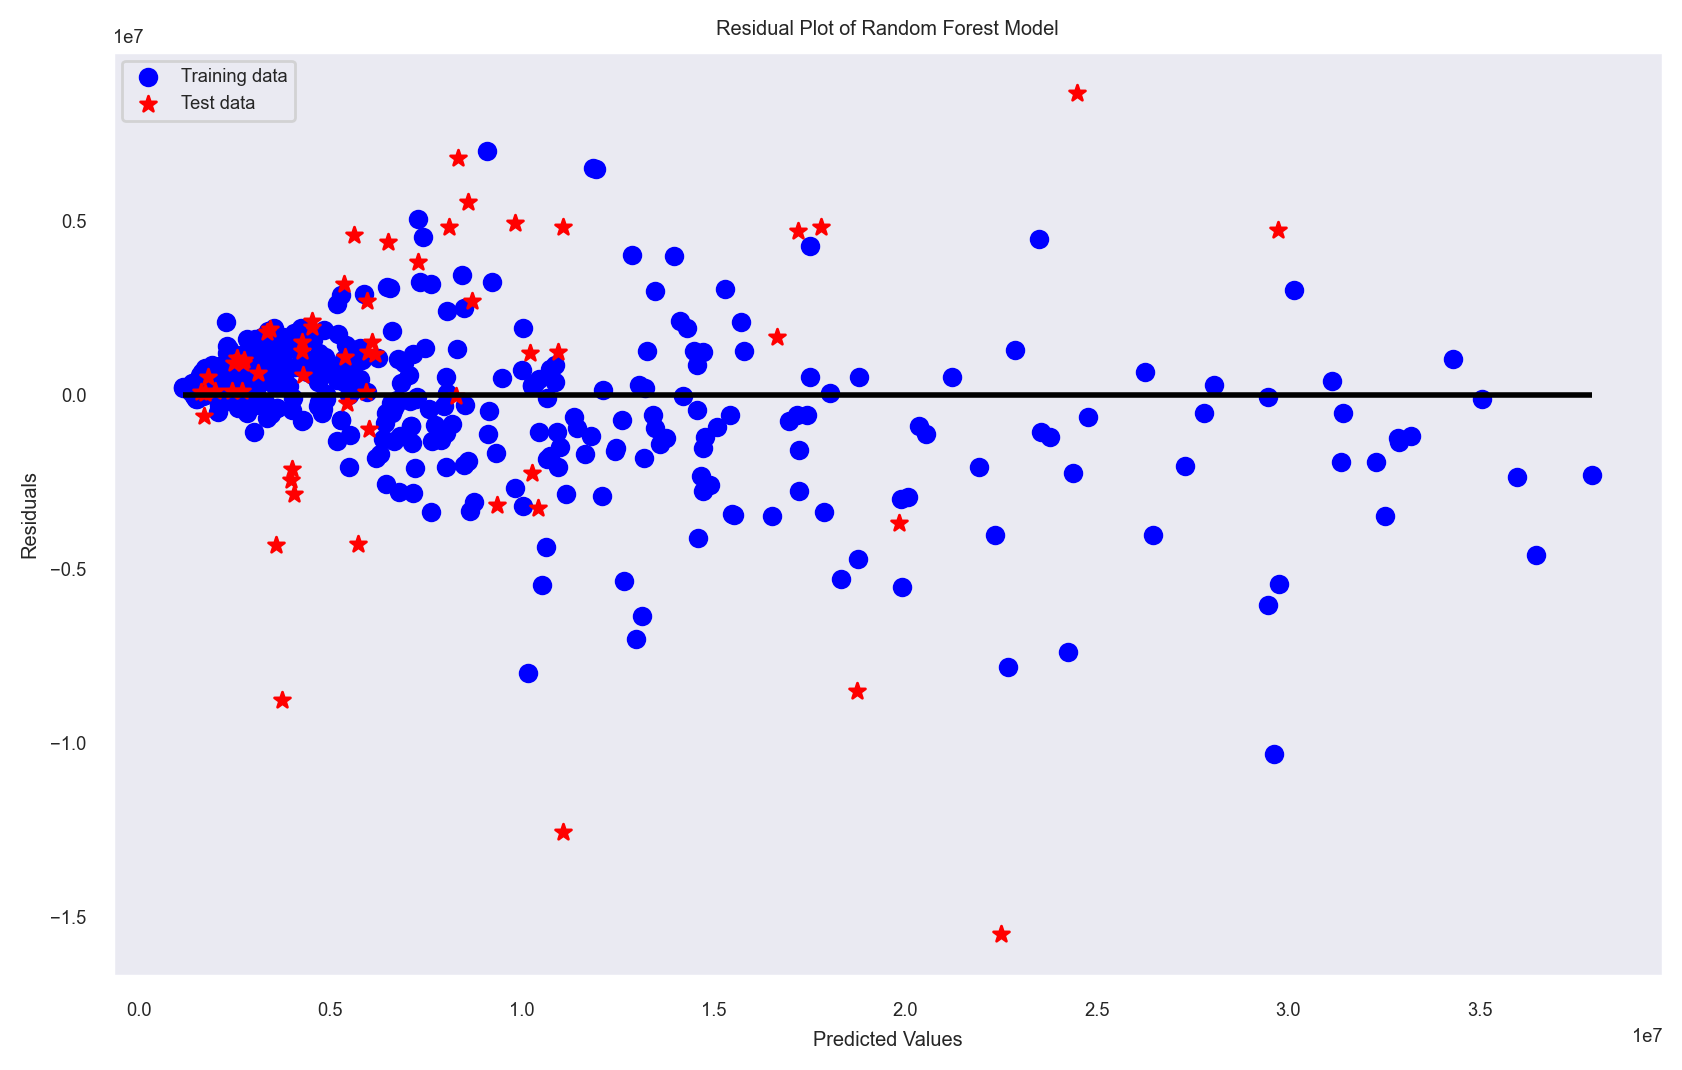

In [60]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, y_train_pred - y_train, c="blue", marker="o", label="Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c="red", marker="*", label="Test data")
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot of Random Forest Model')
plt.hlines(y=0, xmin=np.min(y_train_pred), xmax=np.max(y_train_pred), color='black', lw=2)
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [61]:
!pip install shap

In [62]:
import shap
explainer = shap.KernelExplainer(rf_model.predict, scaled_X_test)
shap_values = explainer.shap_values(scaled_X_test)

shap.initjs()

  0%|          | 0/58 [00:00<?, ?it/s]

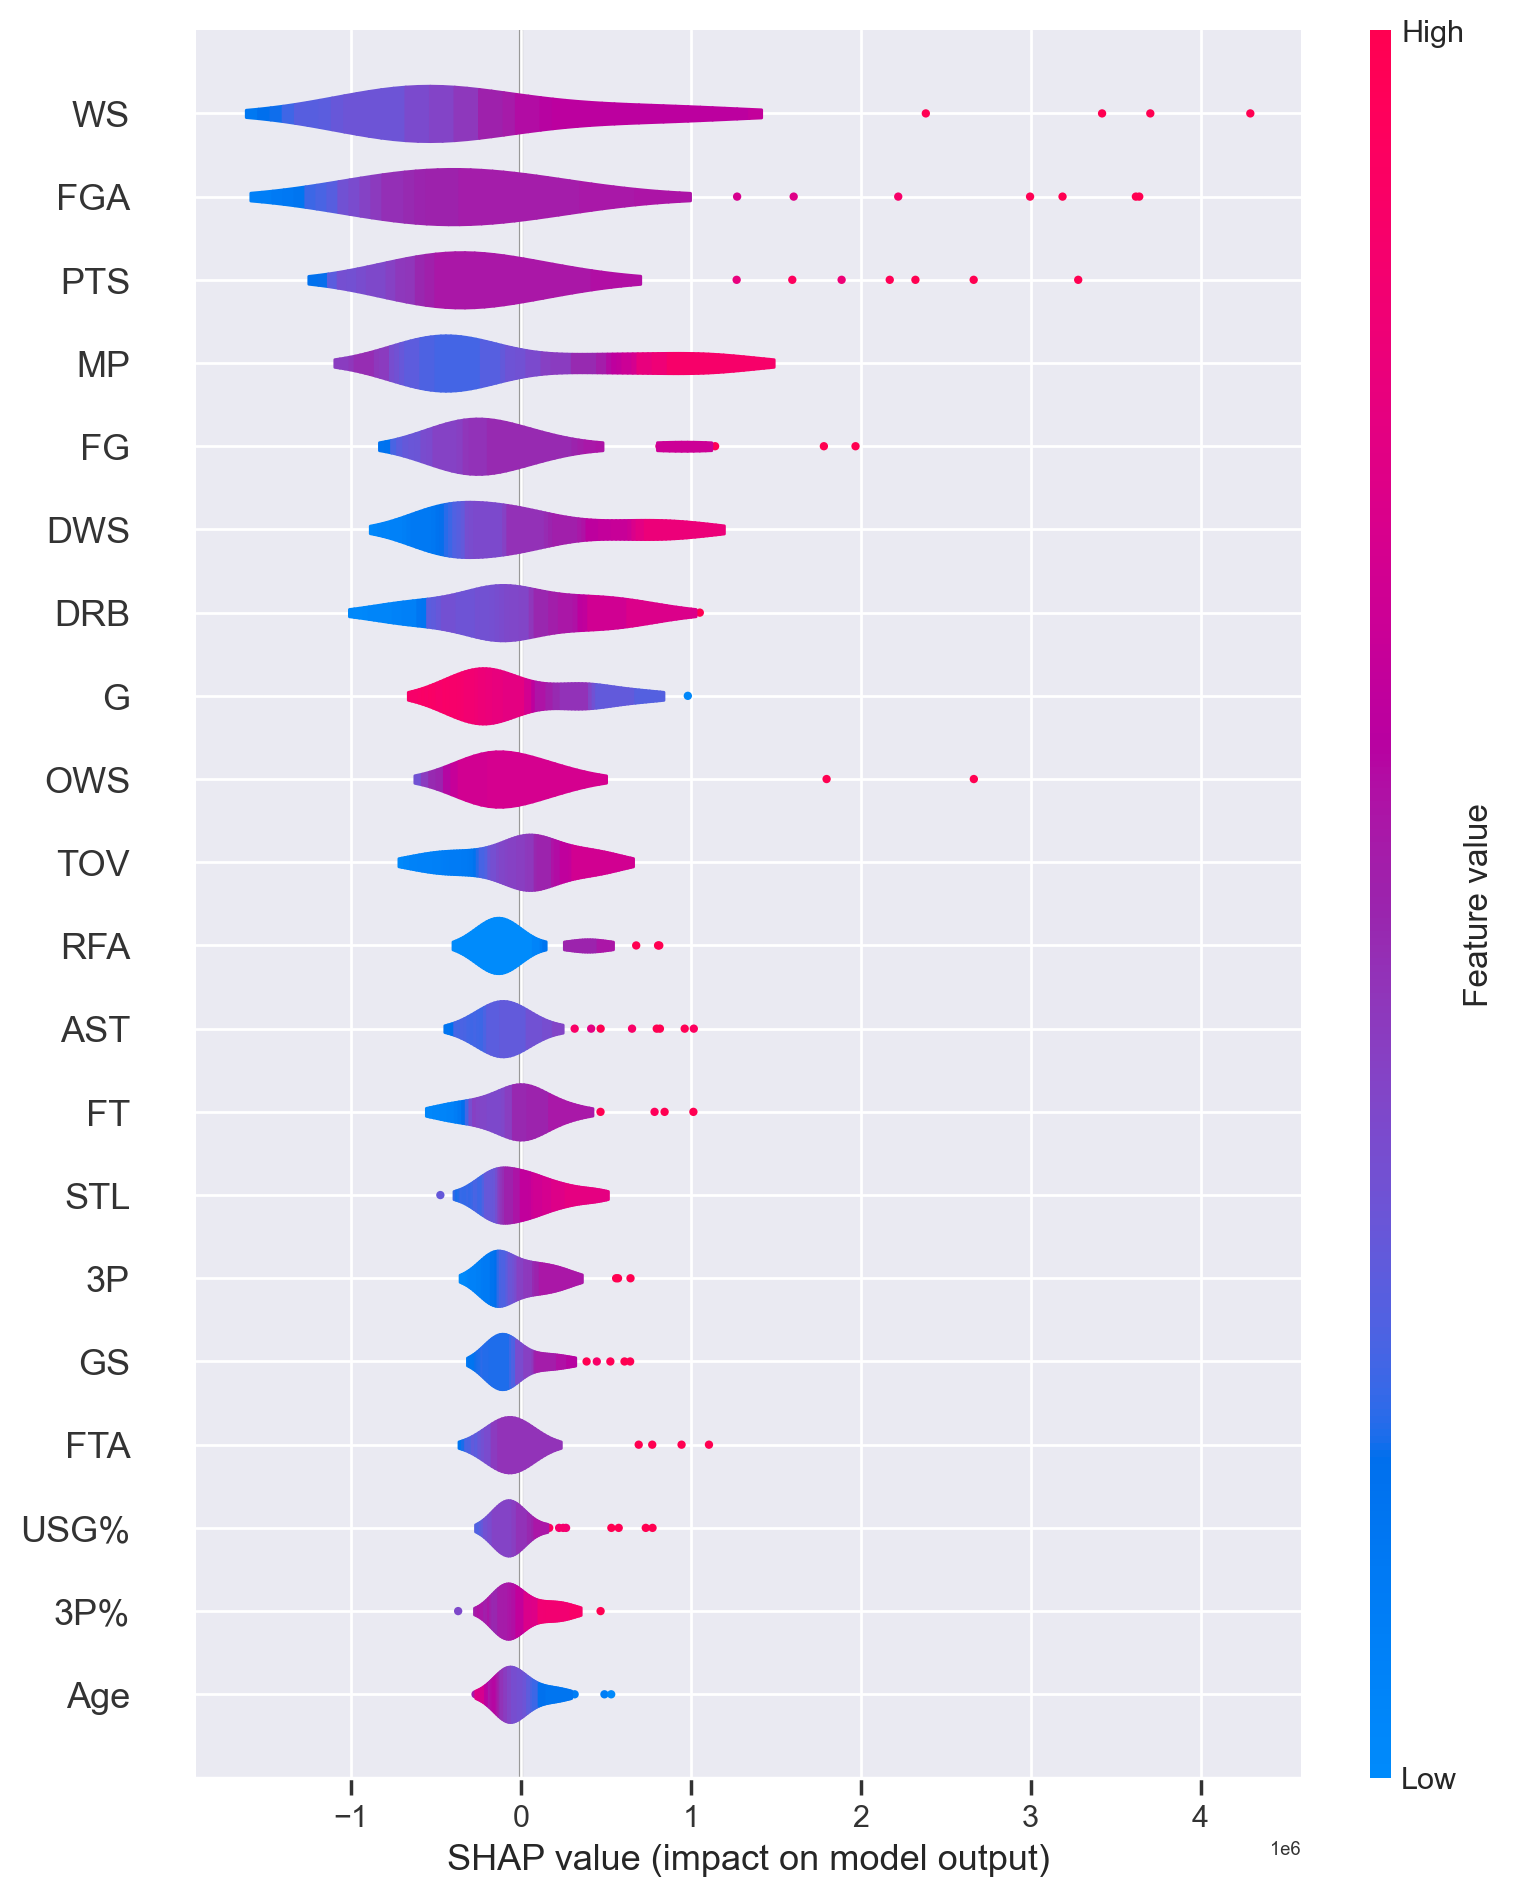

In [63]:
shap.summary_plot(shap_values, X_test, plot_type='violin') # Top 20 variáveis


### Prediction

In [64]:
df2.columns

Index(['Deal_Year', 'Salary Cap', 'Luxury Tax Line'], dtype='object', name=0)

In [75]:
df3 = pd.read_excel('NBA Talent Analysis Part BandC data.xlsx', sheet_name = 'Forecast Data')
new_df3 = pd.merge(df3, df2, on='Deal_Year', how='left')

#df2 = pd.read_excel('NBA Talent Analysis Part BandC data.xlsx', sheet_name = 'NBA Salary Cap History')

In [76]:
#X_test_new = new_df3.drop(columns={'Player', 'Deal Average Salary', 'Deal_Year','VORP'})
X_test_new = new_df3.drop(columns={'Player', 'Deal Average Salary', 'Deal_Year', 'Salary Cap', 'Luxury Tax Line','VORP'})
scaler = StandardScaler()

scaler.fit(X_train)
scaled_X_test = scaler.transform(X_test_new)

In [77]:
y_test_pred = rf_model.predict(scaled_X_test)

In [78]:
y_test_pred

array([20771697.7 , 13454539.72,  8088664.  ])

In [79]:
df3['Deal Average Salary'] = y_test_pred

In [80]:
df3

,Player,Deal Average Salary,Deal_Year,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,3PAr,FTr,USG%,OWS,DWS,WS,VORP,RFA
0,Danny Glover,20771697.70,2020,31,62,62,1834,358,817,0.44,178,439,0.41,0.55,266,298,0.89,34,288,322,119,42,5,76,75,1160,0.54,0.36,24.60,4.50,1.90,6.30,2.40,0
1,Mike Meyers,13454539.72,2020,30,62,62,1936,355,810,0.44,142,348,0.41,0.53,181,220,0.82,59,252,311,86,47,30,97,180,1033,0.43,0.27,21.90,2.10,1.50,3.60,0.90,0
2,David Bowie,8088664.00,2020,27,54,4,1583,265,610,0.43,200,472,0.42,0.60,104,122,0.85,35,210,245,92,37,33,59,139,834,0.77,0.20,19.00,3.00,0.50,3.50,1.10,0
